In [1]:
import os
import torch
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.virtual.scans import run_quad_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.analysis import plot_scan_data, plot_predicted_screens
from phase_space_reconstruction.train import train_1d_scan
from bmadx.plot import plot_projections

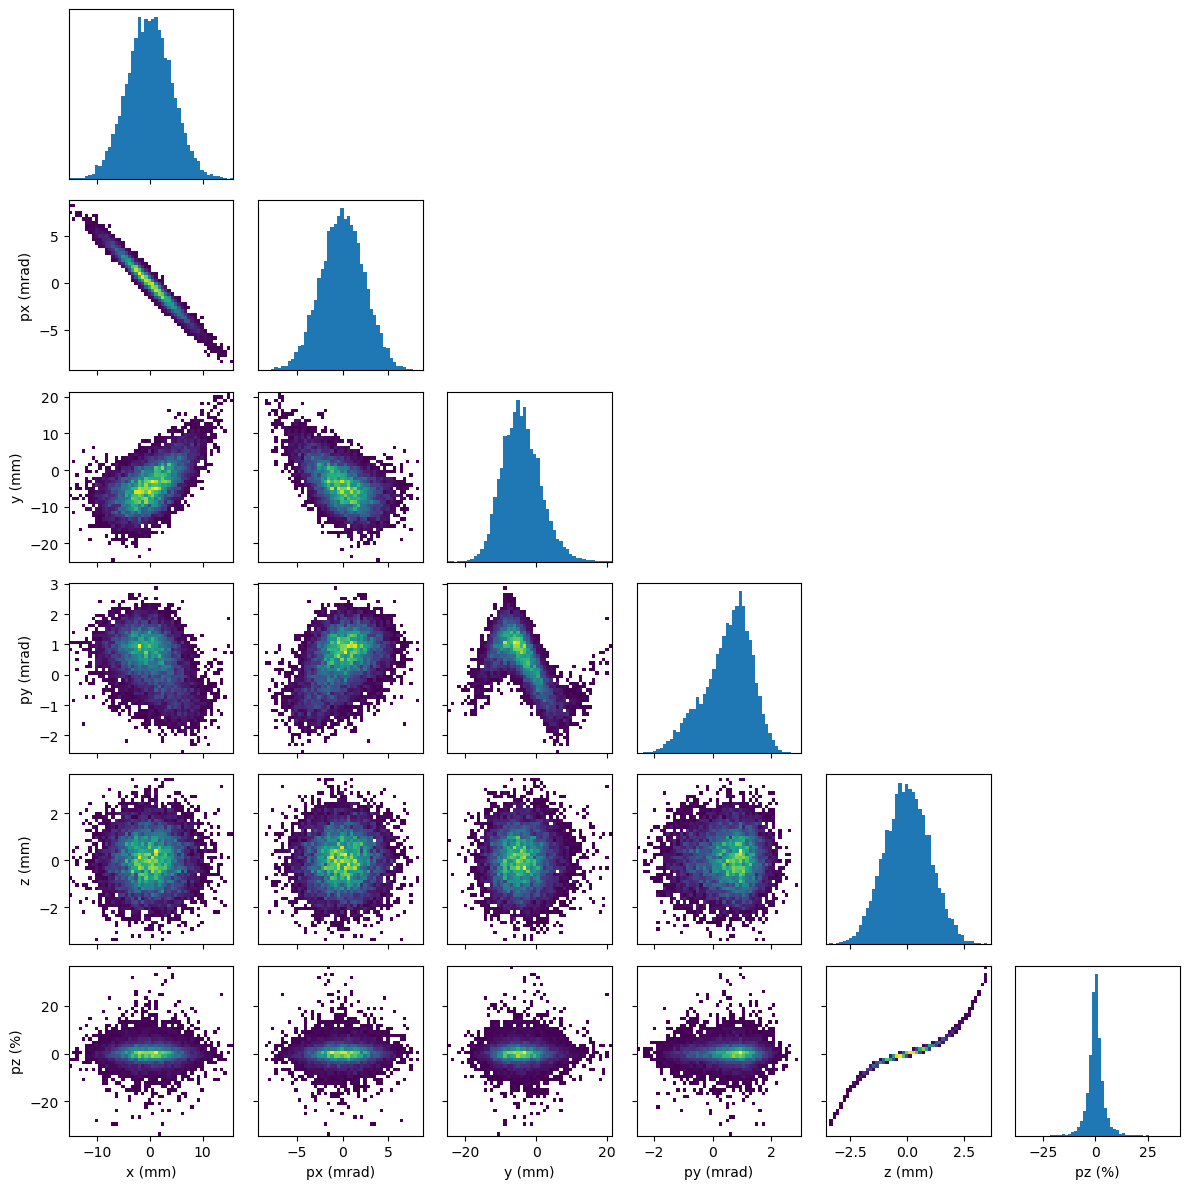

In [2]:
data_dir = 'data'

gt_beam = torch.load(os.path.join(data_dir, 'gt_beam.pt'))
fig, ax = plot_projections(gt_beam.numpy_particles())
plt.show()

In [3]:
# diagnostic beamline:
p0c = 43.36e6
lattice = quadlet_tdc_bend(p0c)
lattice.elements[0].K1.data = torch.tensor(0)
lattice.elements[2].K1.data = torch.tensor(-8.86)
lattice.elements[4].K1.data = torch.tensor(7.30)


# quadrupole strengths for scan (reshape as: n_quad_strengths x n_images_per_quad_strength x 1)
n_ks = 20
ks = torch.linspace(-10, 10, n_ks).reshape((n_ks,1,1))

# split in training and testing sets
train_ks = ks[::2]
test_ks = ks[1::2]

# create diagnostic screen: 
bins = torch.linspace(-50, 50, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

/home/jp/Repositories/PS-Reconstruction/phase_space_reconstruction/phase_space_reconstruction/diagnostics.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("bandwidth", torch.tensor(bandwidth))


In [4]:
# generate and save train and test datasets
train_dset = run_quad_scan(gt_beam, lattice, screen, train_ks, scan_quad_id=6, save_as=os.path.join('data', 'train.dset'))
test_dset = run_quad_scan(gt_beam, lattice, screen, test_ks, scan_quad_id=6, save_as=os.path.join('data', 'test.dset'))
print(train_dset.k.shape)
print(train_dset.images.shape)

dataset saved as 'data/train.dset'
dataset saved as 'data/test.dset'
torch.Size([10, 1, 1])
torch.Size([10, 1, 200, 200])


image size = 100 x 100 mm
test samples boxed in orange


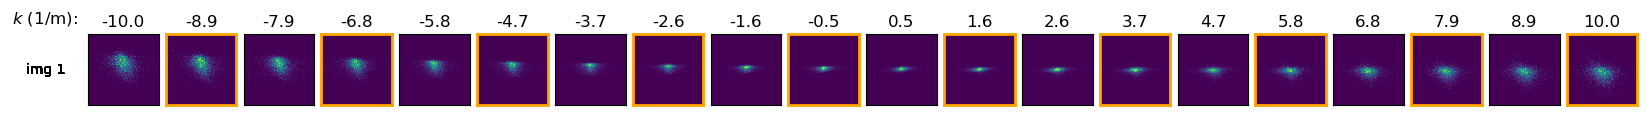

In [5]:
# plot generated datasets
fig, ax = plot_scan_data(train_dset, test_dset, bins, bins)
plt.show()

In [6]:
# training
pred_beam = train_1d_scan(train_dset, lattice, p0c, screen, n_epochs=2000, device='cuda')

Using device: cuda


/home/jp/mambaforge/envs/ps-reconstruction/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0 tensor(4211532., device='cuda:0', grad_fn=<MulBackward0>)
100 tensor(1020470.1250, device='cuda:0', grad_fn=<MulBackward0>)
200 tensor(993851.6875, device='cuda:0', grad_fn=<MulBackward0>)
300 tensor(960578.3750, device='cuda:0', grad_fn=<MulBackward0>)
400 tensor(948034.5000, device='cuda:0', grad_fn=<MulBackward0>)
500 tensor(956743.4375, device='cuda:0', grad_fn=<MulBackward0>)
600 tensor(951373.6250, device='cuda:0', grad_fn=<MulBackward0>)
700 tensor(931808.8125, device='cuda:0', grad_fn=<MulBackward0>)
800 tensor(913108.5000, device='cuda:0', grad_fn=<MulBackward0>)
900 tensor(920792.2500, device='cuda:0', grad_fn=<MulBackward0>)
1000 tensor(911295.7500, device='cuda:0', grad_fn=<MulBackward0>)
1100 tensor(896105.5625, device='cuda:0', grad_fn=<MulBackward0>)
1200 tensor(903058.4375, device='cuda:0', grad_fn=<MulBackward0>)
1300 tensor(912333.7500, device='cuda:0', grad_fn=<MulBackward0>)
1400 tensor(894763.7500, device='cuda:0', grad_fn=<MulBackward0>)
1500 tensor(924629.1250,

In [7]:
# predicted screens:
pred_dset = run_quad_scan(pred_beam, lattice, screen, ks)

image size = 100 x 100 mm
test samples boxed in orange


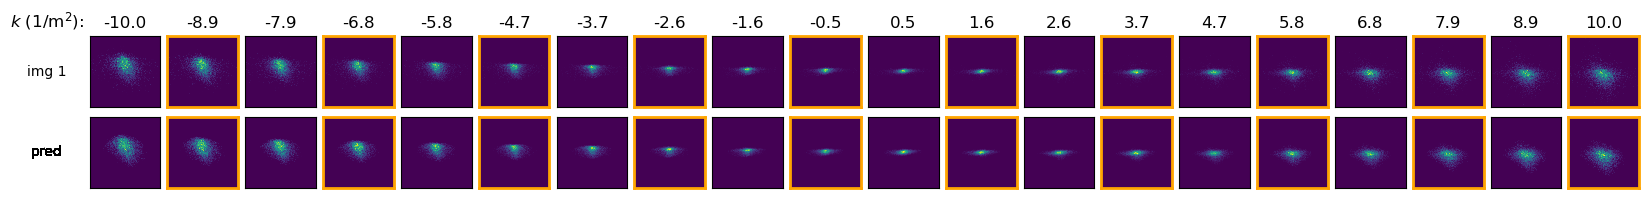

In [8]:
# compare predicted screens with data
fig, ax = plot_predicted_screens(pred_dset, train_dset, test_dset, bins, bins)
plt.show()

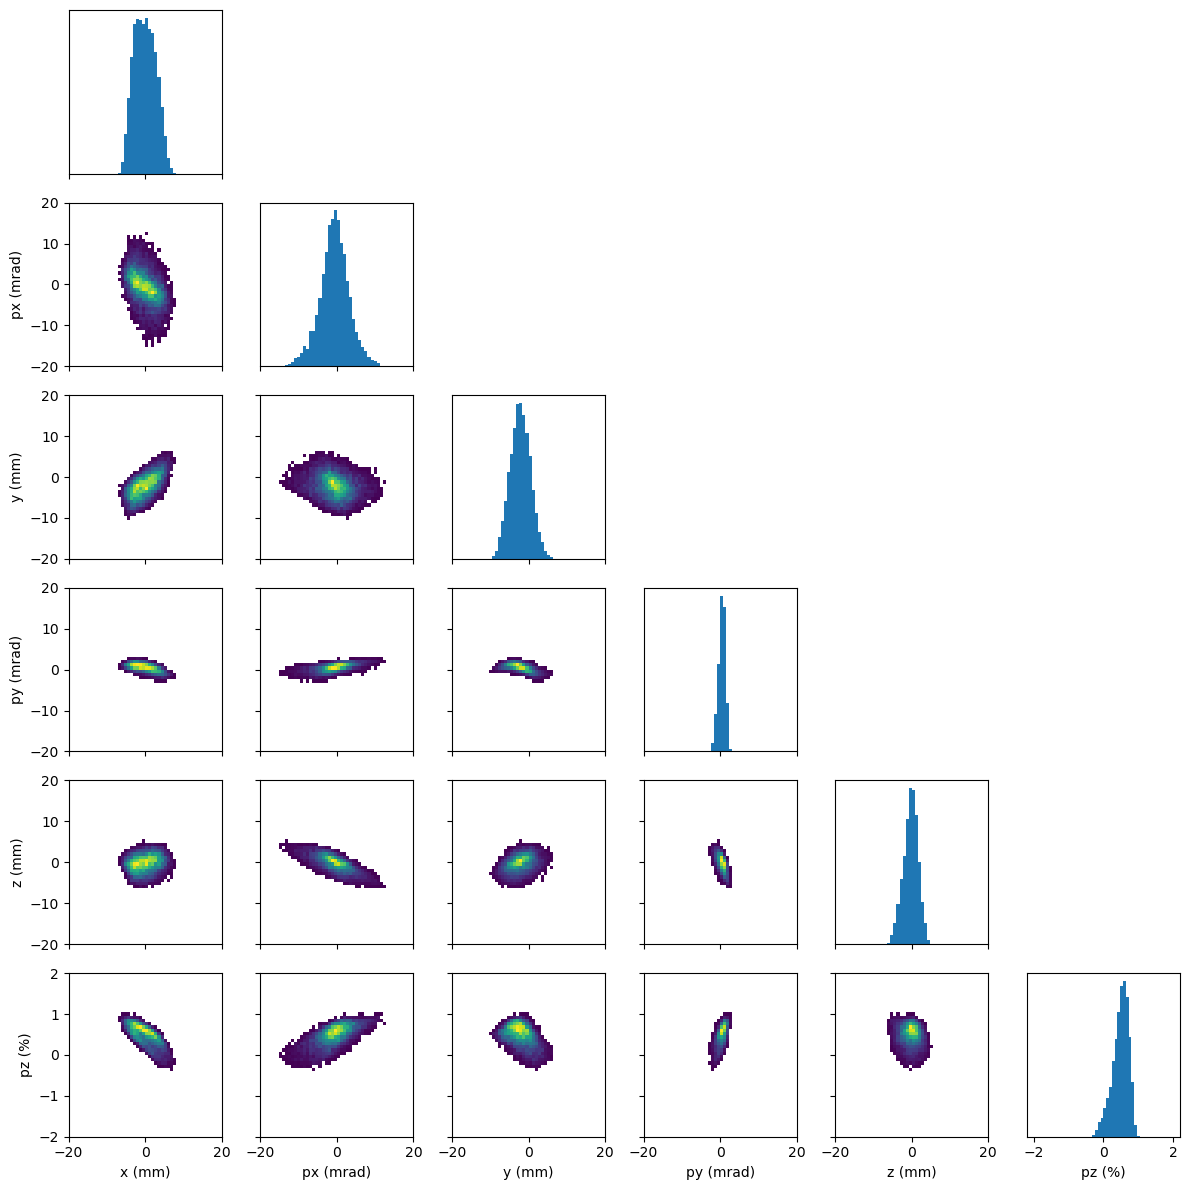

In [9]:
# reconstructed beam projections: 
fig, ax = plot_projections(pred_beam.numpy_particles(),
                           same_lims=True,
                           custom_lims = [-20e-3, 20e-3]
                           )
plt.show()

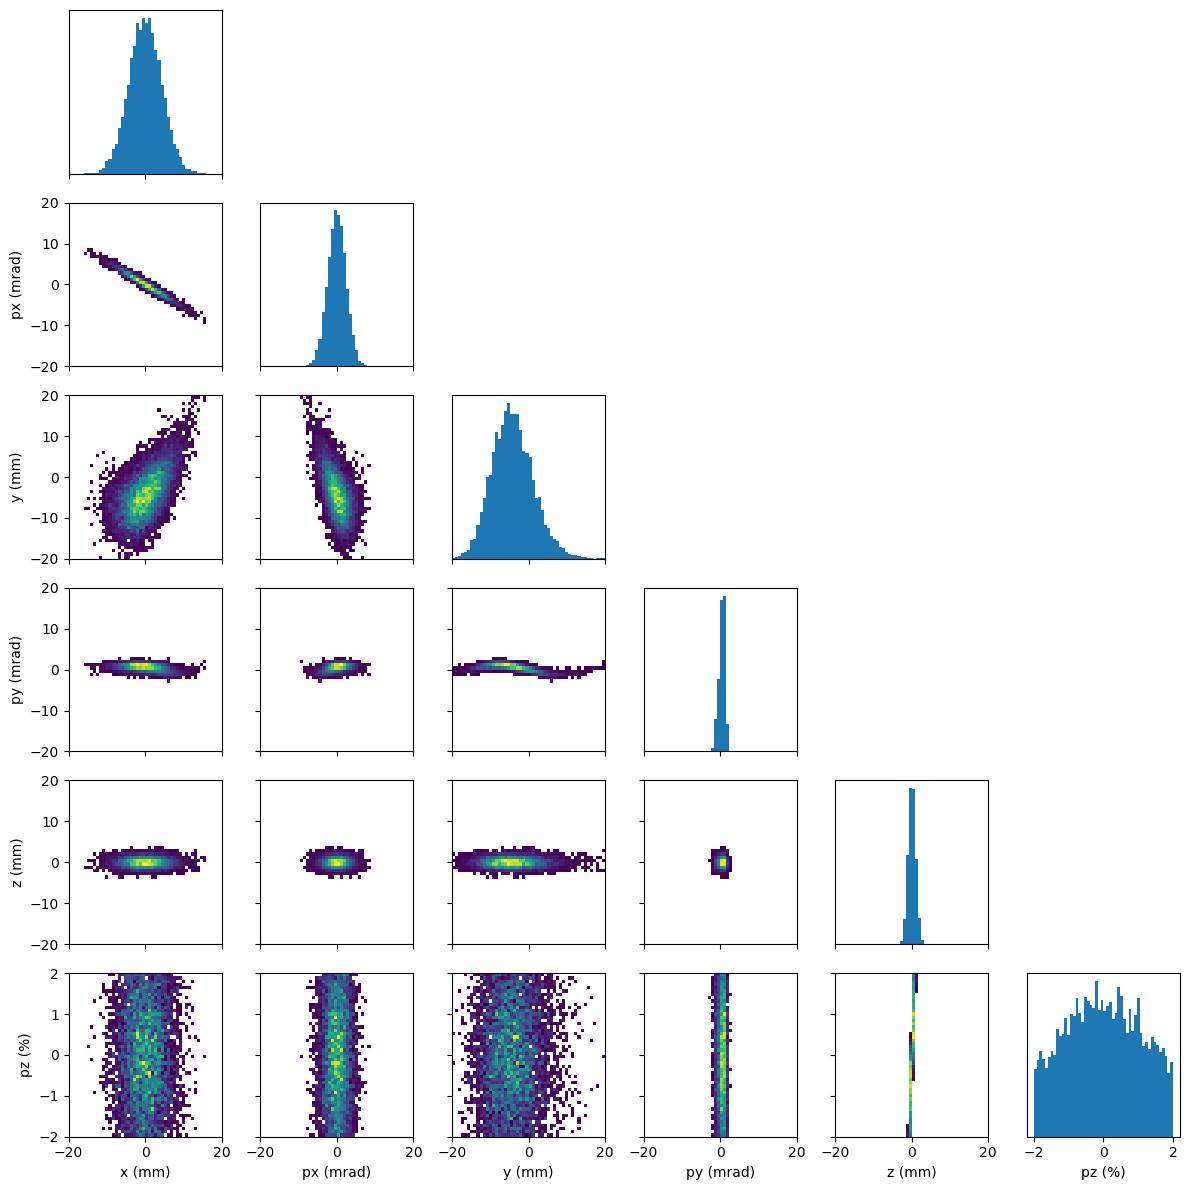

In [10]:
# ground truth beam projections:
fig, ax = plot_projections(gt_beam.numpy_particles(),
                           same_lims=True,
                           custom_lims = [-20e-3, 20e-3])
plt.show()

In [11]:
torch.cuda.empty_cache()

In [25]:
def screen_stats(image, bins_x, bins_y):
    proj_x = image.sum(axis=1)
    proj_y = image.sum(axis=0)
    avg_x = (bins_x*proj_x).sum()/proj_x.sum()
    avg_y = (bins_y*proj_y).sum()/proj_y.sum()
    std_x = (((bins_x*proj_x - avg_x)**2).sum()/proj_x.sum())**(1/2)
    std_y = (((bins_y*proj_y - avg_y)**2).sum()/proj_y.sum())**(1/2)
    return {'avg_x': avg_x,
            'avg_y': avg_y,
            'std_x': std_x,
            'std_y': std_y}



In [30]:
screen_stats(train_dset.images[0,0], bins, bins)

{'avg_x': tensor(-0.0002),
 'avg_y': tensor(0.0072),
 'std_x': tensor(0.0026),
 'std_y': tensor(0.1015)}

In [29]:
train_dset.images.shape

torch.Size([10, 1, 200, 200])

In [32]:
train_dset.k[0,0]

tensor([-10.])

In [15]:
import numpy as np
a = np.array([[1,1,1,1],[2,2,2,2],[3,3,3,3],[4,4,4,4]] )
a

array([[1, 1, 1, 1],
       [2, 2, 2, 2],
       [3, 3, 3, 3],
       [4, 4, 4, 4]])

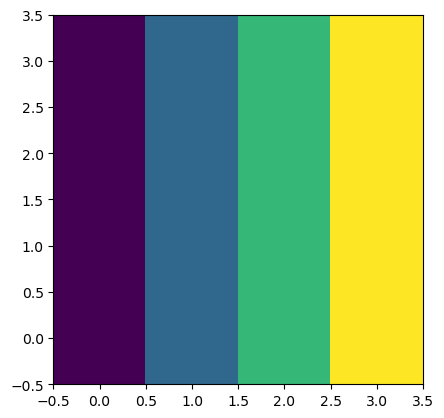

In [19]:
plt.imshow(a.T, origin='lower')

(array([0., 0., 0., 0., 0., 4., 0., 0., 0., 0.]),
 array([ 9.5,  9.6,  9.7,  9.8,  9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5]),
 <BarContainer object of 10 artists>)

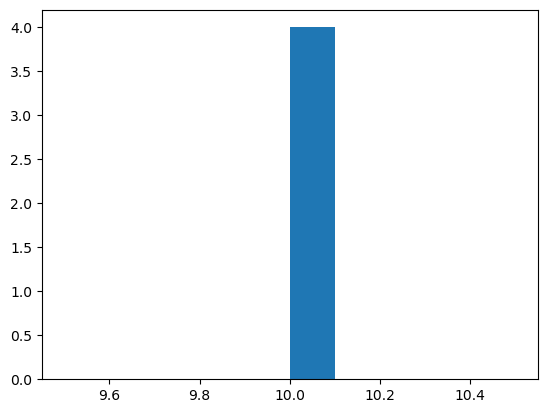

In [23]:
plt.hist(a.sum(axis=0).T)

(array([1., 0., 0., 1., 0., 0., 1., 0., 0., 1.]),
 array([ 4. ,  5.2,  6.4,  7.6,  8.8, 10. , 11.2, 12.4, 13.6, 14.8, 16. ]),
 <BarContainer object of 10 artists>)

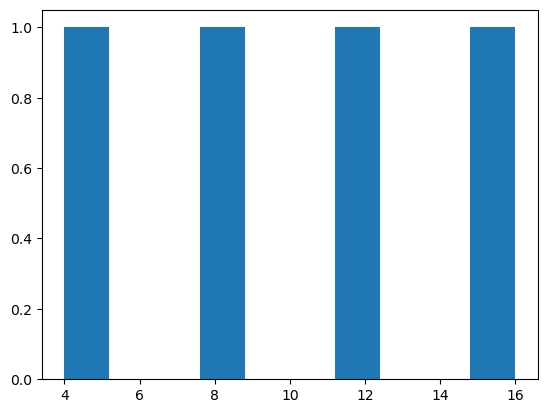

In [24]:
plt.hist(a.sum(axis=1).T)

In [37]:
a.sum(axis=0).sum()

40

In [36]:
a.sum(axis=1).sum()

40